# **BT5** - Ứng dụng của truncated SVD trong việc nén ảnh

In [1]:
# Download ảnh input
!gdown 1M2VLezua7zVIrzSbTXKLgy-1CKg_gmPR

Downloading...
From: https://drive.google.com/uc?id=1M2VLezua7zVIrzSbTXKLgy-1CKg_gmPR
To: /content/chua-mot-cot.jpg
100% 89.4k/89.4k [00:00<00:00, 25.0MB/s]


## **BT5.1** - Ảnh xám

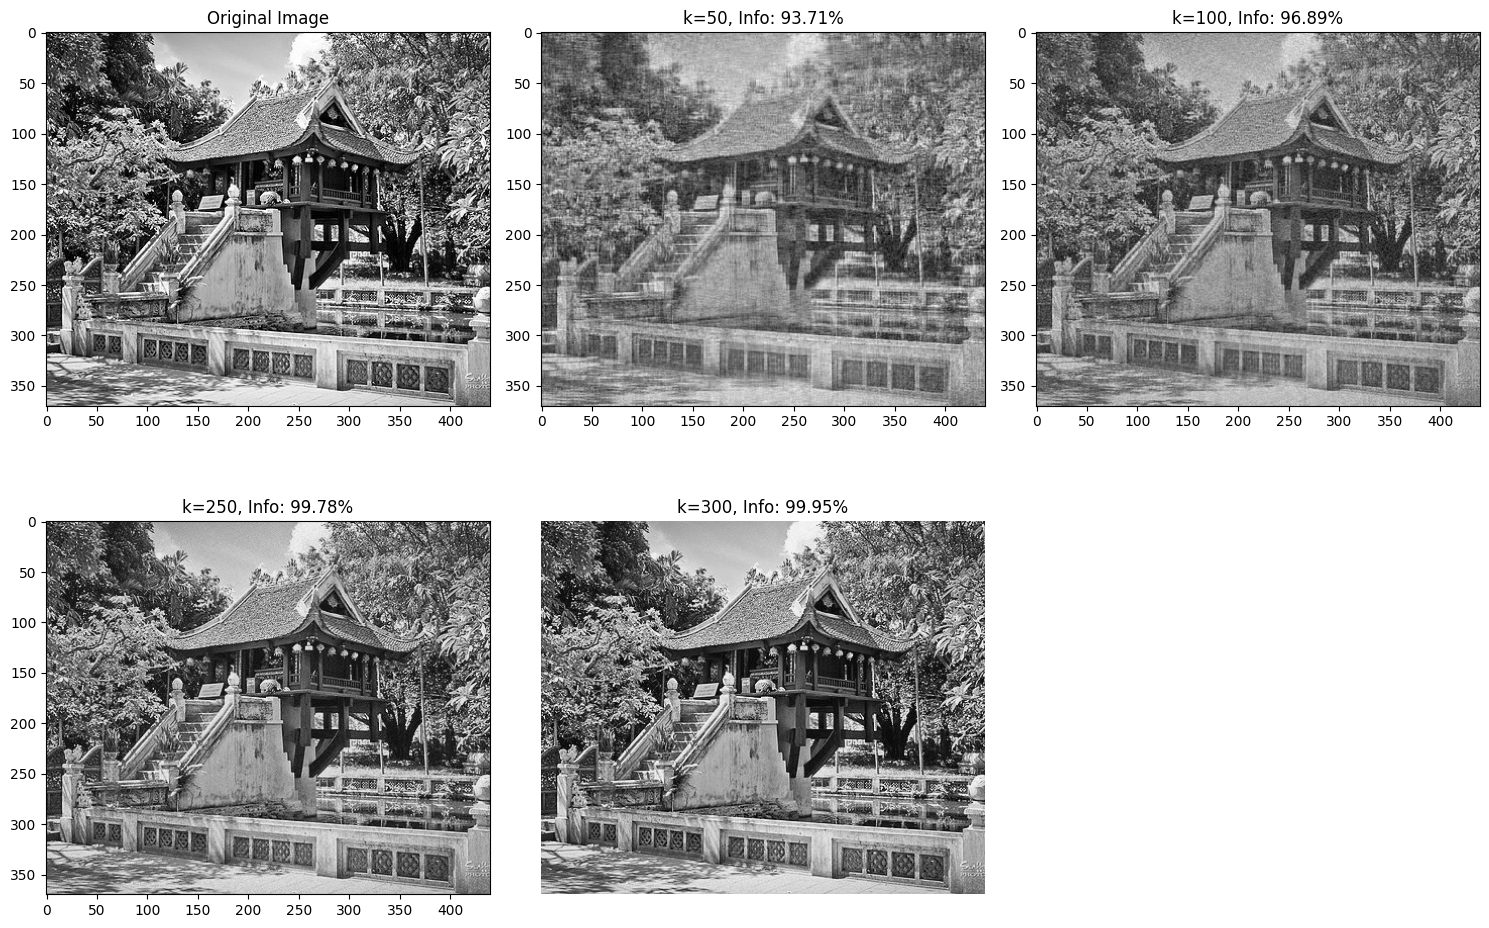

In [4]:
# 1. Khai báo các thư viện cần thiết
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from scipy.linalg import svd

# 2. Dùng hàm để đọc hình ảnh và biến ảnh thành mảng, đặt là A
A = np.array(Image.open('/content/chua-mot-cot.jpg'))

# 3. Nhân A với mảng (0.299, 0.587, 0.114) để tạo ảnh xám
A_gray = A.dot(np.array([0.299, 0.587, 0.114]))

# 4. Tìm truncated SVD của A như trên với 50 số λ lớn nhất được giữ lại
U, S_diag, V_trans = svd(A_gray)
def compute_truncated_svd(A, k):
    U, S_diag, V_trans = svd(A)
    Sigma_small = np.zeros((k, k))
    np.fill_diagonal(Sigma_small, S_diag[:k])
    Sigma_k = Sigma_small
    U_k = U[:, :k]
    V_k_trans = V_trans[:k, :]
    return U_k, Sigma_k, V_k_trans

U_k, Sigma_k, V_k_trans = compute_truncated_svd(A=A_gray, k=50)

# 5. Tạo lại ma trận A từ 3 ma trận của truncated SVD
A_reconstruct = U_k @ Sigma_k @ V_k_trans

# 6. Tính phần trăm lượng thông tin giữ lại
def calculate_information_retained(S_diag, k):
    retained_information = np.sum(S_diag[:k]**2) / np.sum(S_diag**2)
    return round(retained_information * 100, 2)

# 7-8. Vẽ ảnh dùng imshow và làm tương tự với các giá trị λ là 50, 100, 250, 300
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(A_gray, cmap="gray")
plt.title("Original Image")

k_list = [50, 100, 250, 300]
for i, k in enumerate(k_list):
    U_k, Sigma_k, V_k_trans, = compute_truncated_svd(A=A_gray, k=k)
    A_reconstruct = U_k @ Sigma_k @ V_k_trans

    information_retained = calculate_information_retained(S_diag, k)

    plt.subplot(2, 3, i+2)
    plt.imshow(A_reconstruct, cmap="gray")
    plt.title(f"k={k}, Info: {information_retained}%")

plt.tight_layout()
plt.axis("off")
plt.show()


## **BT5.2** - Ảnh màu

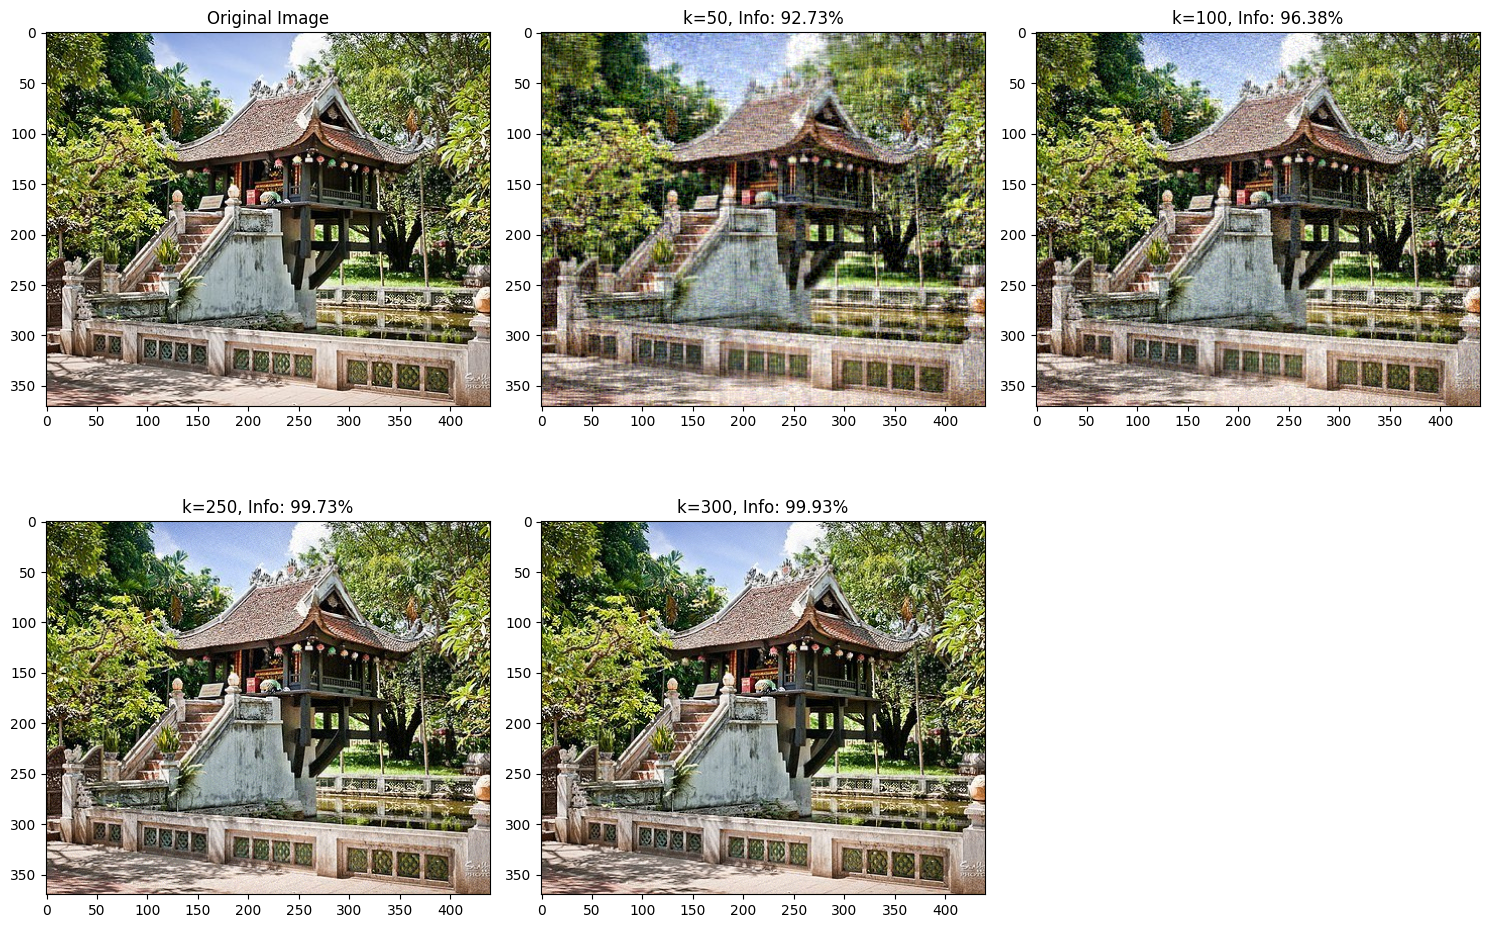

In [6]:
# Khai báo các thư viện cần thiết
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from scipy.linalg import svd

# Đọc hình ảnh và biến nó thành mảng, đặt là A
A = np.array(Image.open('/content/chua-mot-cot.jpg'))

# Áp dụng SVD cho từng kênh màu của ảnh
def compute_truncated_svd_per_channel(A, k):
    channels = []
    for i in range(3):  # Lặp qua 3 kênh màu: R, G, B
        U, S_diag, V_trans = svd(A[:, :, i], full_matrices=False)
        U_k = U[:, :k]
        Sigma_k = np.diag(S_diag[:k])
        V_k_trans = V_trans[:k, :]
        A_reconstruct_channel = U_k @ Sigma_k @ V_k_trans
        channels.append(A_reconstruct_channel)
    return np.stack(channels, axis=2), S_diag

# Tính phần trăm lượng thông tin giữ lại cho mỗi kênh
def calculate_information_retained(S_diag, k):
    retained_information = np.sum(S_diag[:k]**2) / np.sum(S_diag**2)
    return round(retained_information * 100, 2)

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(A)
plt.title("Original Image")

# Dùng các giá trị k khác nhau để tính toán và vẽ các ảnh nén
k_list = [50, 100, 250, 300]
for i, k in enumerate(k_list):
    A_reconstruct, S_diag = compute_truncated_svd_per_channel(A=A, k=k)
    information_retained = calculate_information_retained(S_diag, k)

    plt.subplot(2, 3, i+2)
    plt.imshow(np.clip(A_reconstruct, 0, 255).astype(np.uint8))
    plt.title(f"k={k}, Info: {information_retained}%")

plt.tight_layout()
plt.show()


# **BT6** - Ứng dụng của SVD trong việc giải thuật toán hồi quy tuyến tính

In [7]:
# Download file csv chứa các thông số
!gdown 1xhA2M_aVBmqElP9t4Xwk4AarX_R4CYOY

Downloading...
From: https://drive.google.com/uc?id=1xhA2M_aVBmqElP9t4Xwk4AarX_R4CYOY
To: /content/samsung_phones.csv
100% 1.17k/1.17k [00:00<00:00, 5.13MB/s]


In [14]:
# 1. Khởi tạo ma trận A và vector Y
import pandas as pd
import numpy as np

## Đọc file csv vừa tải về
data = pd.read_csv('/content/samsung_phones.csv')

## Chuyển giá trị cột PRICE sang định dạng số (loại bỏ dấu phẩy và chuyển sang kiểu int)
data['PRICE'] = data['PRICE'].str.replace(',', '').astype(int)

## Tạo ma trận A (các cột RAM, MEMORY, PIN)
A = data[['RAM', 'MEMORY', 'PIN']].values

## Thêm một cột thứ 4 vào ma trận A, cột thứ 4 này gồm các giá trị = 1
ones_column = np.ones(A.shape[0])
A = np.column_stack((A, ones_column))

## Tạo ma trận Y (cột PRICE)
Y = data['PRICE'].values

# 2. Tính định thức của ma trận A^T @ A
def compute_X(A, Y):
    A_T = A.T
    A_T_A = A_T @ A
    det_A_T_A = np.linalg.det(A_T_A)
    if det_A_T_A >= 1e-6:
        X = np.linalg.inv(A_T_A) @ A_T @ Y
    else:
        ## i. Tìm SVD của ma trận A
        U, Sigma, V_trans = np.linalg.svd(A)
        ## ii. Tìm pseudo-inverse của ma trận Sigma
        Sigma_pseudo_inv = np.zeros((U.shape[1], V_trans.shape[0]))
        for i in range(len(Sigma)):
            if Sigma[i] > 1e-6:  # Tránh chia cho 0
                Sigma_pseudo_inv[i, i] = 1. / Sigma[i]
        ## iii. Tính X=V.Σ+.U^T.Y
        X = V_trans.T @ Sigma_pseudo_inv @ U.T @ Y
    return X

# 3. Tính giá chiếc điện thoại mới
X = compute_X(A, Y)
predict_price = np.array([4, 64, 4000, 1]) @ X
print(f"Giá tiền của chiếc điện thoại mới là: {predict_price}")

Giá tiền của chiếc điện thoại mới là: 4897997.375889859
